## Week 10 Homework

---

### Q1: perform Bayesian Logistic Regression

- For a binary outcome dataset you find interesting (perhaps from kaggle.com?)
- Model the outcome as a bernoulli random variable and use a **logit link** function
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than the `pm.MvNormal` version
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics




In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Set random seed for reproducibility
np.random.seed(42)

# Load dataset (Titanic dataset - predicting survival)
print("Loading dataset...")
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(url)

# Data preprocessing
print("Preprocessing data...")
# Fill missing ages with median
data["Age"] = data["Age"].fillna(data["Age"].median())
# Extract features and target
X = data[["Pclass", "Age", "SibSp", "Parch", "Fare"]].copy()
y = data["Survived"].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add intercept column
X_with_intercept = np.column_stack([np.ones(X_scaled.shape[0]), X_scaled])
feature_names = ['Intercept'] + list(X.columns)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_with_intercept, y, test_size=0.2, random_state=42
)

# Define and fit the Bayesian logistic regression model
print("Fitting Bayesian logistic regression model...")
with pm.Model() as model:
    # Priors for coefficients (intercept + features)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=X_train.shape[1])

    # Linear predictor
    eta = pm.math.dot(X_train, betas)

    # Logit link function
    p_survival = pm.math.invlogit(eta)

    # Likelihood (Bernoulli)
    y_obs = pm.Bernoulli("y_obs", p=p_survival, observed=y_train)

    # MCMC sampling
    trace = pm.sample(
        draws=4000,
        tune=2000,
        target_accept=0.95,
        return_inferencedata=True,
        cores=1  # Use single core for stability
    )

# Analyze results
print("Generating posterior summary...")
summary = az.summary(trace, hdi_prob=0.94)
print(summary)

# MCMC diagnostics
print("\nComputing MCMC diagnostics...")
r_hat = az.rhat(trace).to_dataframe()
ess = az.ess(trace).to_dataframe()
print(f"R-hat values (closer to 1 is better): {r_hat}")
print(f"\nEffective Sample Size (higher is better): {ess}")

# Make predictions
print("Making predictions...")
def predict_proba(X_data, trace):
    """Calculate predicted probabilities from trace"""
    # Extract samples
    beta_samples = trace.posterior["betas"].values
    beta_samples = beta_samples.reshape(-1, X_data.shape[1])

    # Calculate logits for each sample
    logits = np.dot(X_data, beta_samples.T)

    # Convert to probabilities
    probs = 1 / (1 + np.exp(-logits))
    return probs

# Get probabilities for training and test sets
train_probs = predict_proba(X_train, trace)
test_probs = predict_proba(X_test, trace)

# Calculate mean probabilities
train_prob_mean = train_probs.mean(axis=1)
test_prob_mean = test_probs.mean(axis=1)

# Convert to binary predictions
train_pred = (train_prob_mean > 0.5).astype(int)
test_pred = (test_prob_mean > 0.5).astype(int)

# Model evaluation
train_accuracy = np.mean(train_pred == y_train)
test_accuracy = np.mean(test_pred == y_test)
print(f"\nModel Performance:")
print(f"Train Accuracy: {train_accuracy:.3f}")
print(f"Test Accuracy: {test_accuracy:.3f}")

print("Analysis complete.")

# Print interpretation of coefficients
print("\nCoefficient Interpretation:")
for i, name in enumerate(feature_names):
    posterior = trace.posterior["betas"].values[:, :, i].flatten()
    prob_positive = np.mean(posterior > 0)
    mean_value = np.mean(posterior)
    print(f"- {name}: mean = {mean_value:.4f}, P(β > 0) = {prob_positive:.3f}")

Loading dataset...
Preprocessing data...
Fitting Bayesian logistic regression model...


Output()

Generating posterior summary...
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0] -0.532  0.085  -0.687   -0.371      0.001    0.001    7978.0   
betas[1] -0.705  0.114  -0.919   -0.495      0.002    0.001    5455.0   
betas[2] -0.418  0.095  -0.600   -0.244      0.001    0.001    6931.0   
betas[3] -0.278  0.103  -0.482   -0.094      0.001    0.001    7632.0   
betas[4]  0.180  0.094   0.001    0.354      0.001    0.001    6744.0   
betas[5]  0.239  0.129   0.006    0.489      0.002    0.001    5861.0   

          ess_tail  r_hat  
betas[0]    5847.0    1.0  
betas[1]    5425.0    1.0  
betas[2]    6250.0    1.0  
betas[3]    5885.0    1.0  
betas[4]    5597.0    1.0  
betas[5]    5690.0    1.0  

Computing MCMC diagnostics...
R-hat values (closer to 1 is better):                 betas
betas_dim_0          
0            1.000236
1            1.000343
2            1.000108
3            1.000217
4            1.000265
5            1.000058

Effective Samp

<Figure size 1200x800 with 0 Axes>

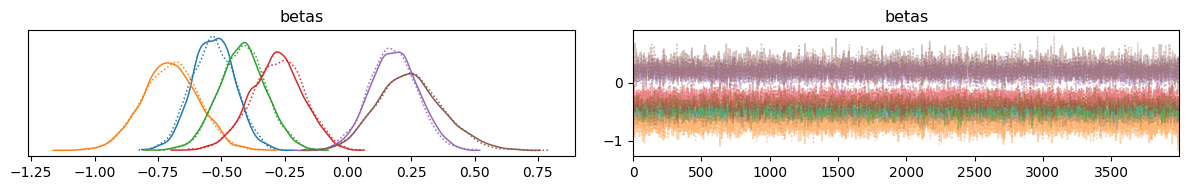

In [ ]:
# Trace plots
plt.figure(figsize=(12, 8))
az.plot_trace(trace)
plt.tight_layout()
plt.savefig('trace_plots.png')

The trace plots above help assess MCMC sampling quality and convergence, demonstrating whether the full parameter space has been explored, the chains have been mixed well, and whether ther are no trends or stickiness. Judging the two plots, the posterior distributions of the beta show the estimated densities of the regression coefficients. By displaying the distributions being far from 0, it suggests that the predictor has a strong infleunce on survival. However, the spread indicates uncertainty in the parameter estimates. On the right side, the MCMC trace plot depicts how smapled values evolve across iterations. Here, it shows the chains fluctuating around a stable mean, suggesting a good sign of convergence. Furthermore, no indicaitions of strong upward or downward trends suggest no sampling bias espcially when the chains overlap, indicating independent sampling.



<Figure size 1200x800 with 0 Axes>

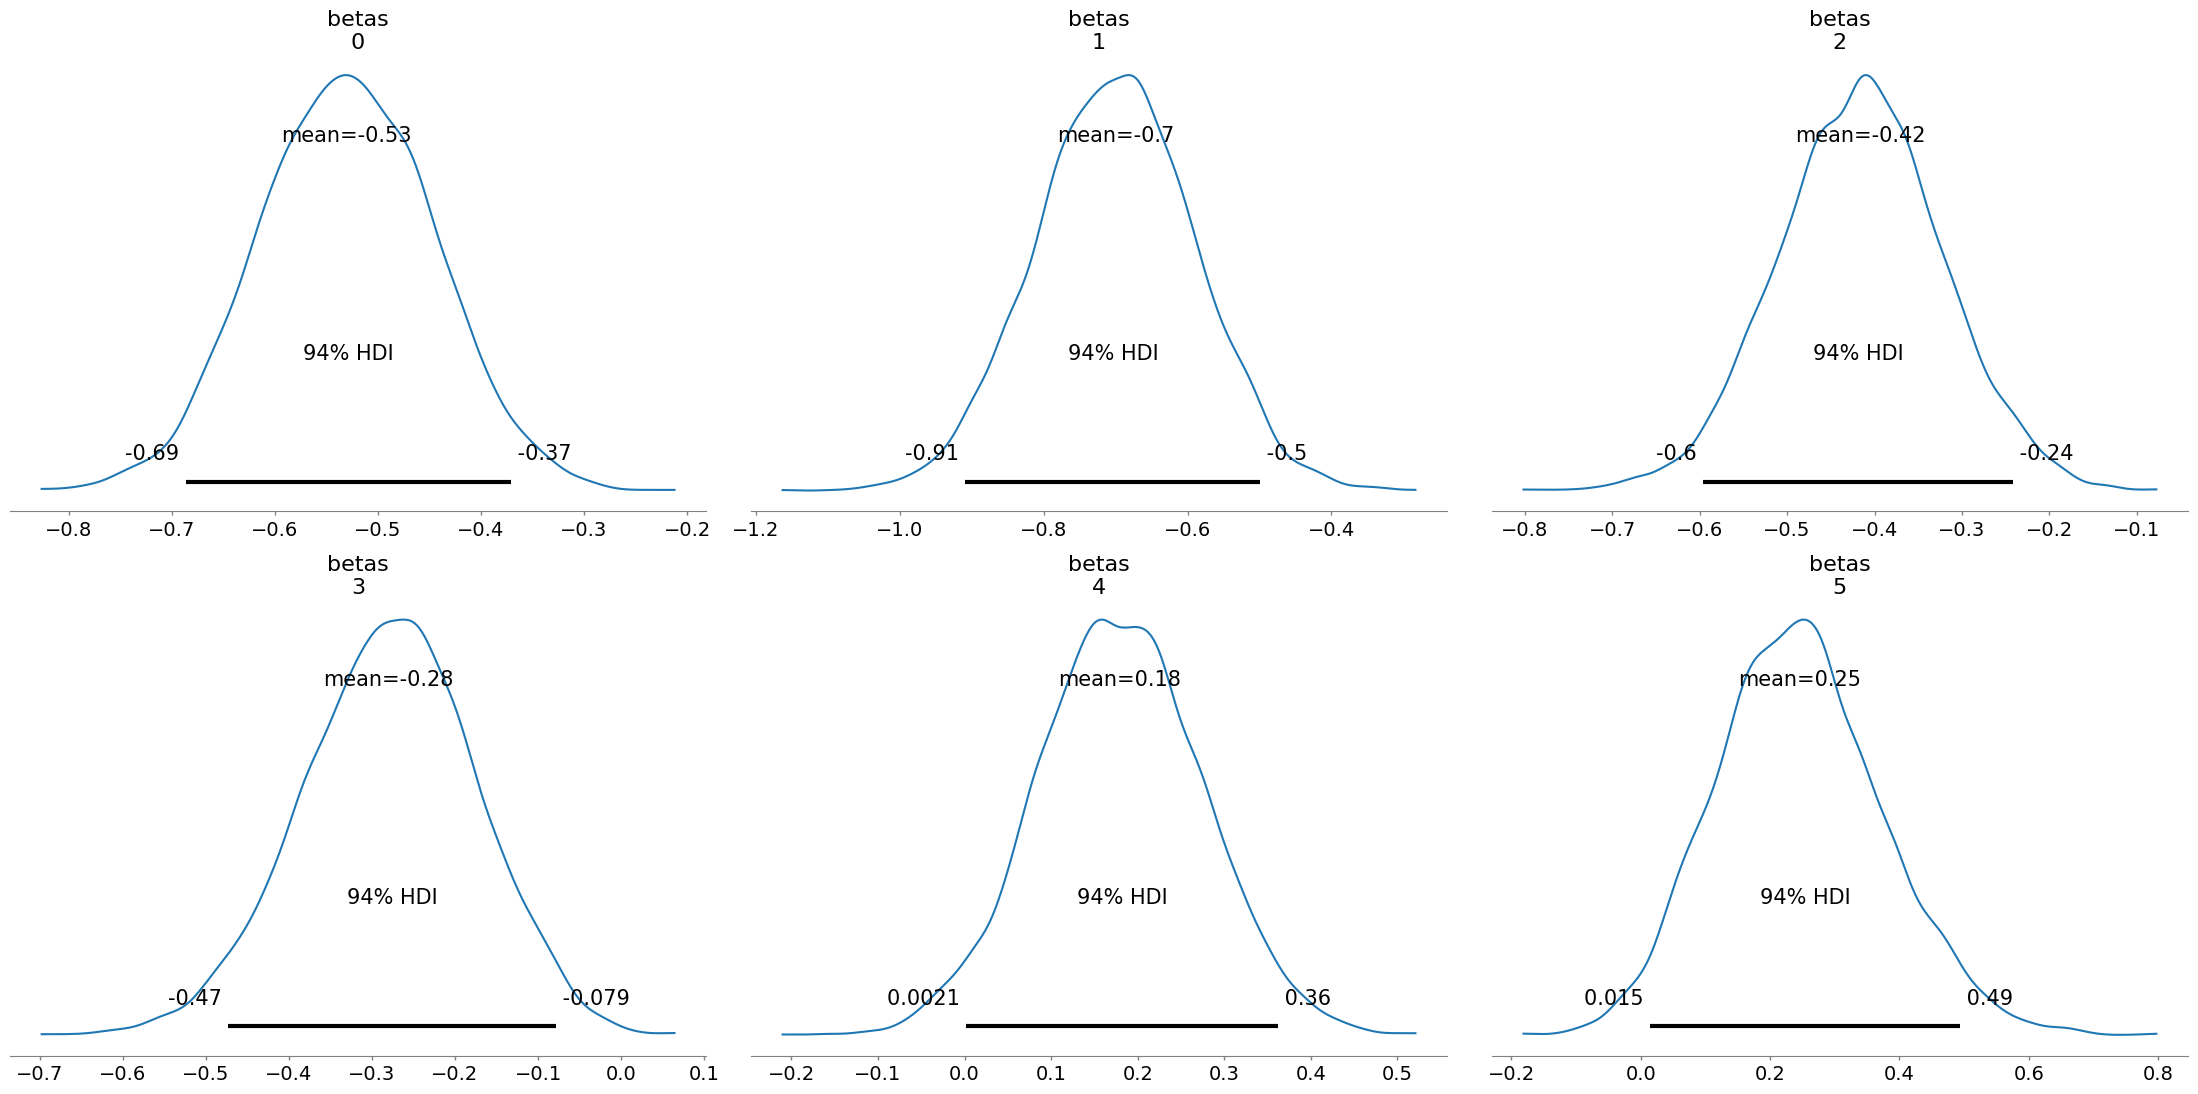

In [ ]:
# Posterior distributions
plt.figure(figsize=(12, 8))
az.plot_posterior(trace, var_names=["betas"], hdi_prob=0.94)
plt.tight_layout()
plt.savefig('coefficient_posteriors.png')

We use the posterior distributions to help interpret the learned regression coefficients of the bayesian logistic regression by showing the most probable values of each coefficient after considering both prior information and the observed data. In the plots above we see the regression coeffiecints of the model being represented where the peak of each curve represents the most probable estiamte for that coefficient. The negative coefficients for betas 0 to 3 suggests that higher values of these features decrease the probablity of survival. As an example, beta 1 is strongly negative, meaning that in being in a lower-class ticket significantly reduces survival probabilty. The positive coefficients as seen in betas 4 and 5 suggests that higher fare payements and having family on board might increase survival probabilities.

<Figure size 1000x600 with 0 Axes>

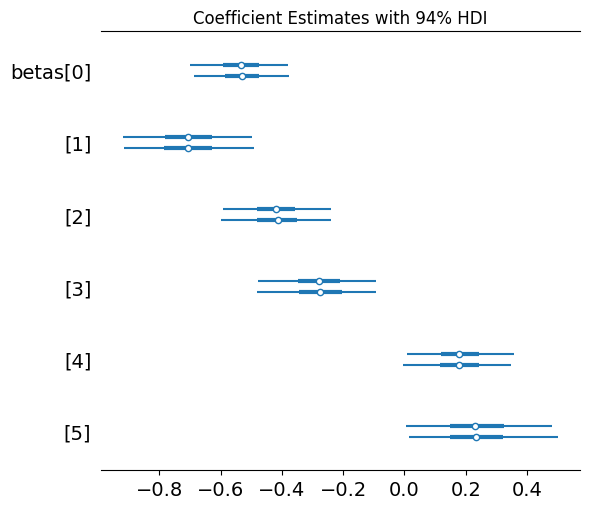

In [ ]:
# Forest plot
plt.figure(figsize=(10, 6))
az.plot_forest(trace, var_names=["betas"], hdi_prob=0.94)
plt.title("Coefficient Estimates with 94% HDI")
plt.tight_layout()
plt.savefig('forest_plot.png')

Forest plots help provide a concise visual summary of the estimated regression coefficients and their uncertainty. Instead of displaying full posterior distirbutions, these plots focus on the mean estimate and credible intervals. In the plot above, the bayesian credible intervals at 94% HDI are represented for the six regression coeffieicnts. The negative coeffients \(betas 0 to 3), aligning with the posterior distirbution plots, suggest a strong negative effect on survival. In this case, higher-class passengers had better survival odds, older passengers had lower survival rates, and having more siblings/spouses aboard reduced survival probability. Moreover, the positive coefficients, betas 4 and 5, demonstrate an increase in survival probability. Finally, the shorter the HDI, the more precise the stimates.

<Figure size 1200x800 with 0 Axes>

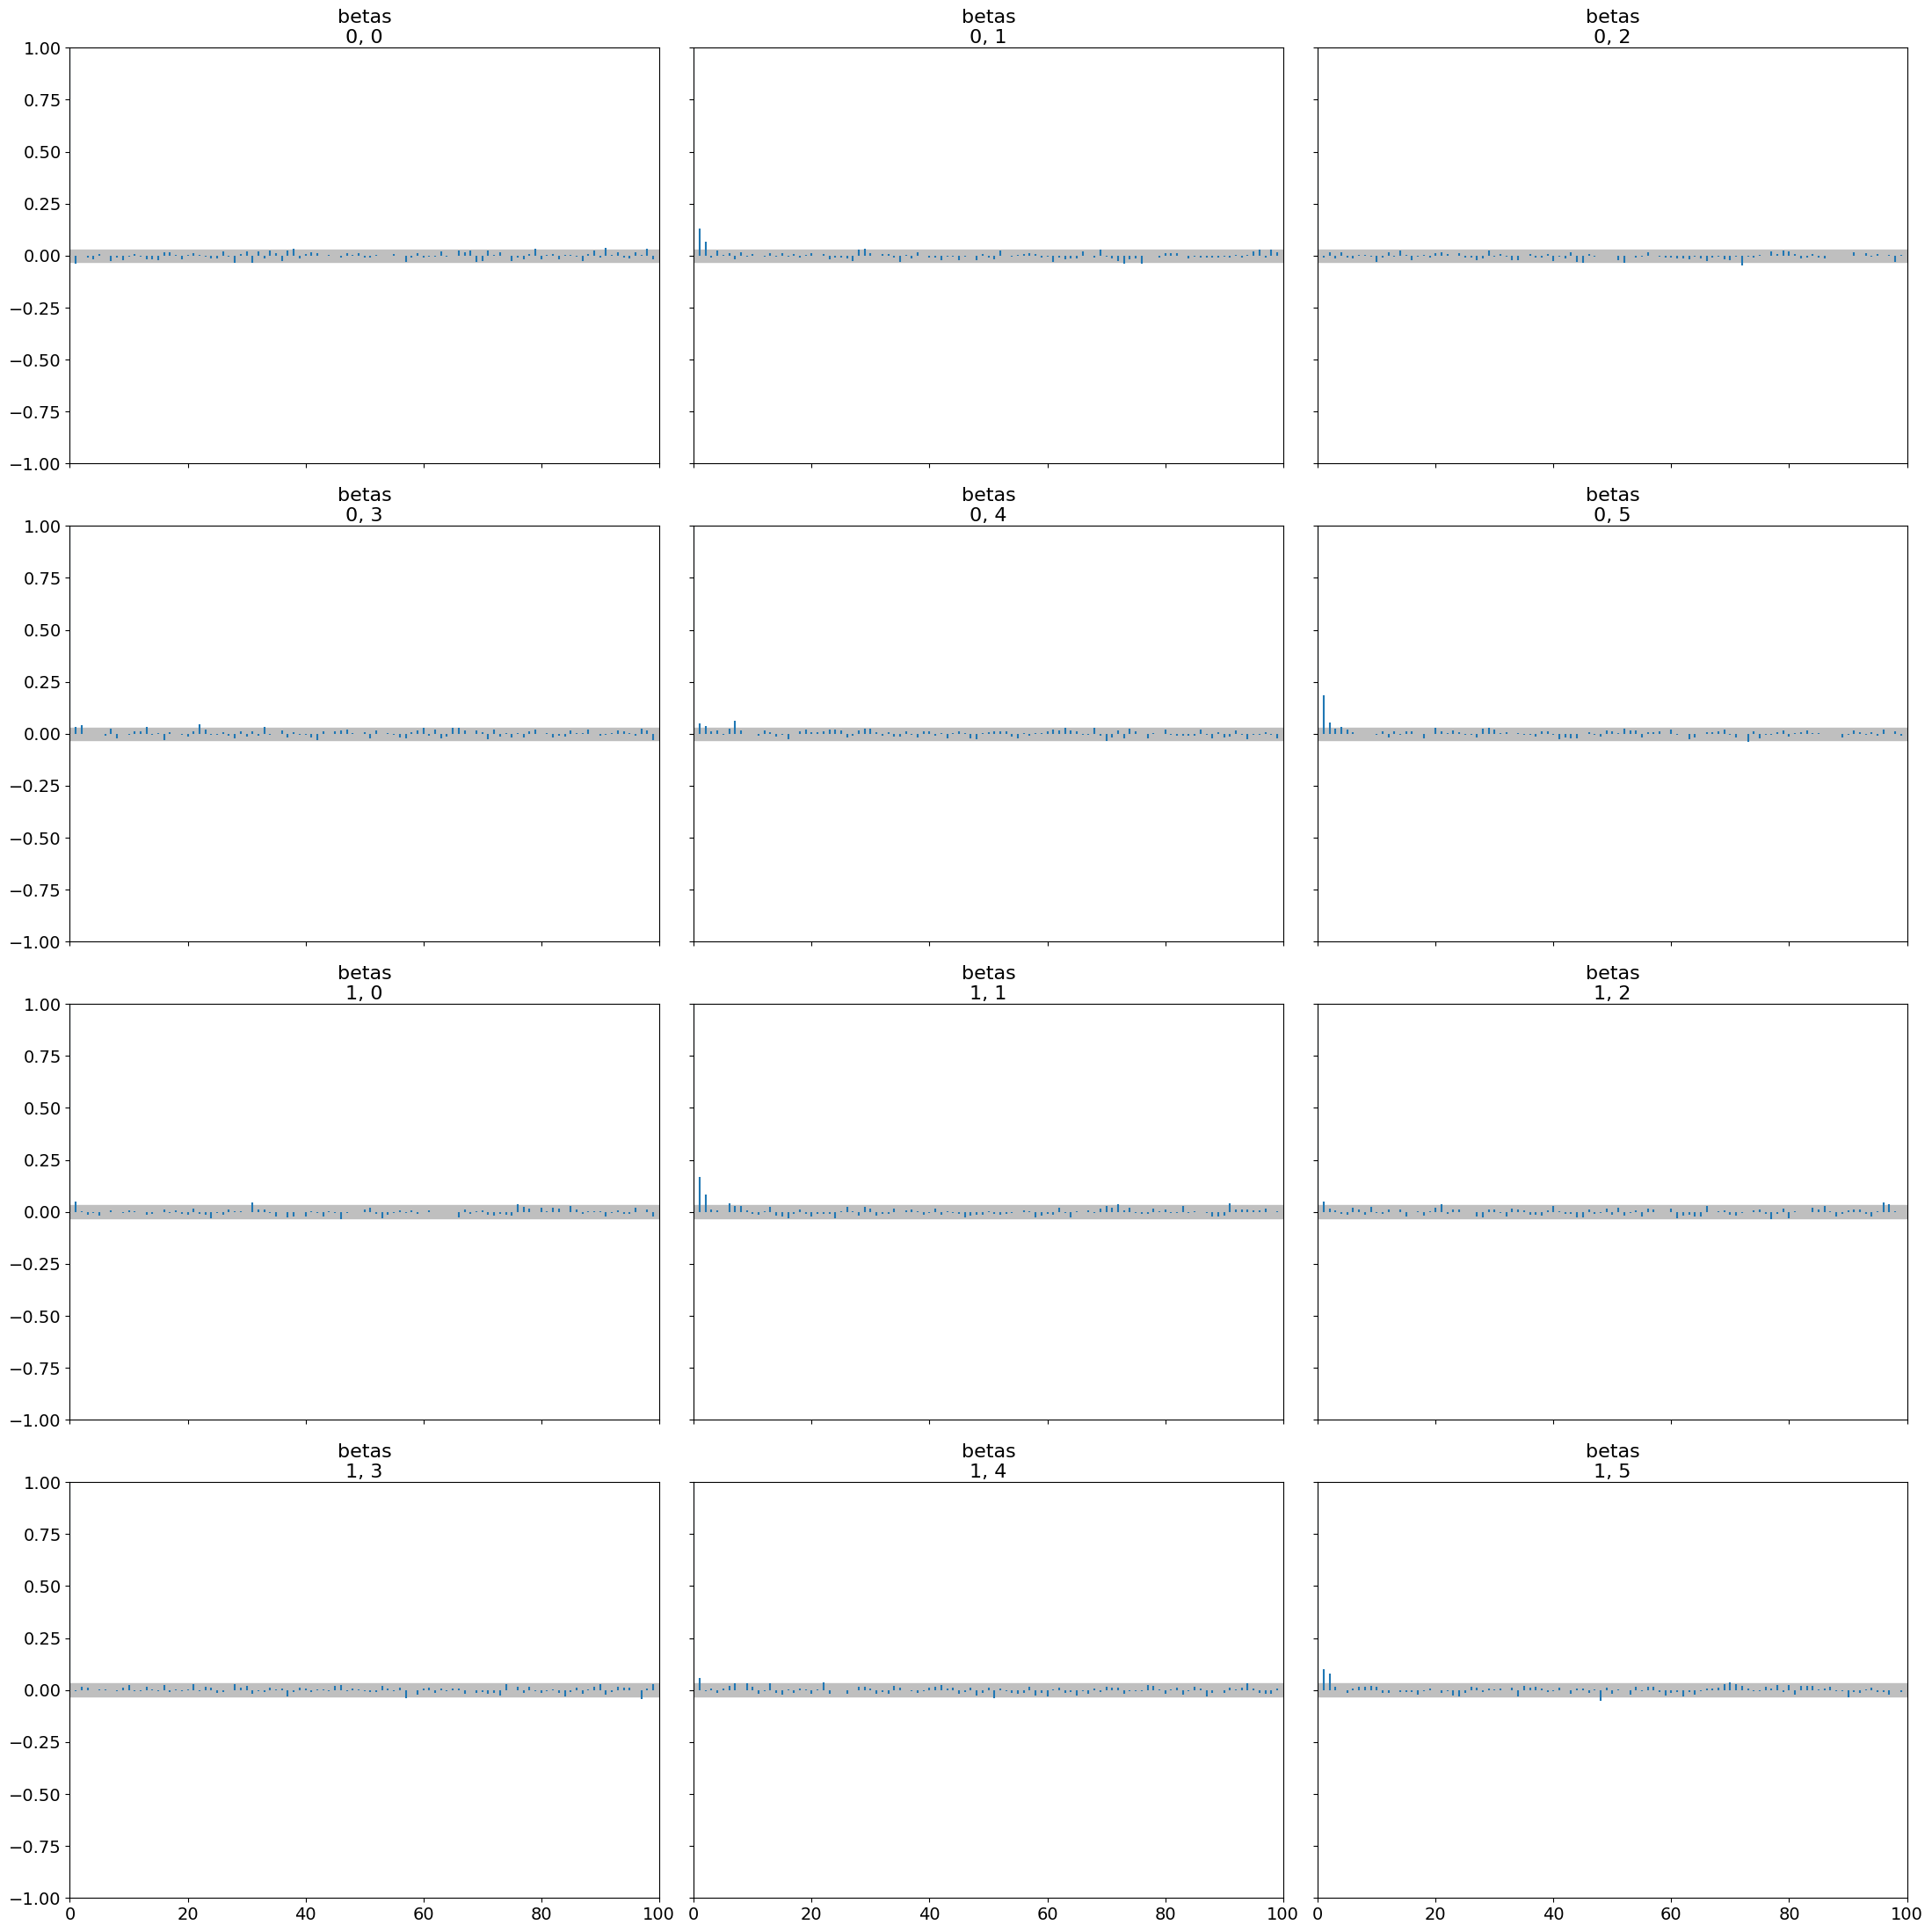

In [ ]:
# Autocorrelation
plt.figure(figsize=(12, 8))
az.plot_autocorr(trace)
plt.tight_layout()
plt.savefig('autocorrelation.png')

Autocorrelations plots are curical for evaluating whether the MCMC samples are independent enough. In the plots above, most plots demonstrate very low autocorrelation across lags with occasional small spikes. The values are nearly flat and close to zero which suggests the MCMC sampler is generating independent samples efficiently. Therefore, it suggest the model has converged well and does not require any additional tuning.

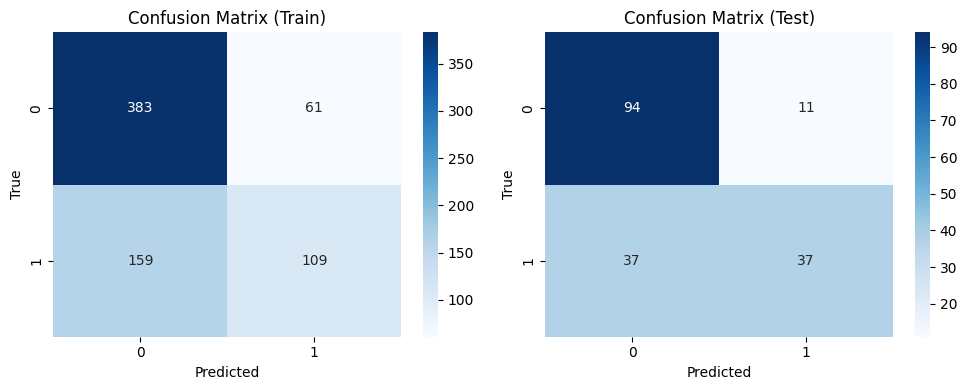

In [ ]:
# Confusion Matrix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
cm_train = confusion_matrix(y_train, train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Train)')
plt.ylabel('True')
plt.xlabel('Predicted')

plt.subplot(1, 2, 2)
cm_test = confusion_matrix(y_test, test_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Test)')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrices.png')

The confusion matrices provide a clear picture of the model's performance on both the training and test datasets. In both cases, the model demonstrates a stronger ability to correctly identify passengers who did not survive (true negatives). However, there is a notable presence of false negatives, meaning the model frequently fails to predict actual survivors. This imbalance in performance likely stems from the inherent class imbalance in the Titanic dataset, where the number of non-survivors significantly outweighs the number of survivors. The also model shows a slightly better performance on the testing data than the training data. This indicates that the model is generalizing well to unseen data, and is not over fitting to the training data. Given the context of the dataset, the high number of false negatives could be a significant issue, as it implies a failure to accurately predict those who survived.

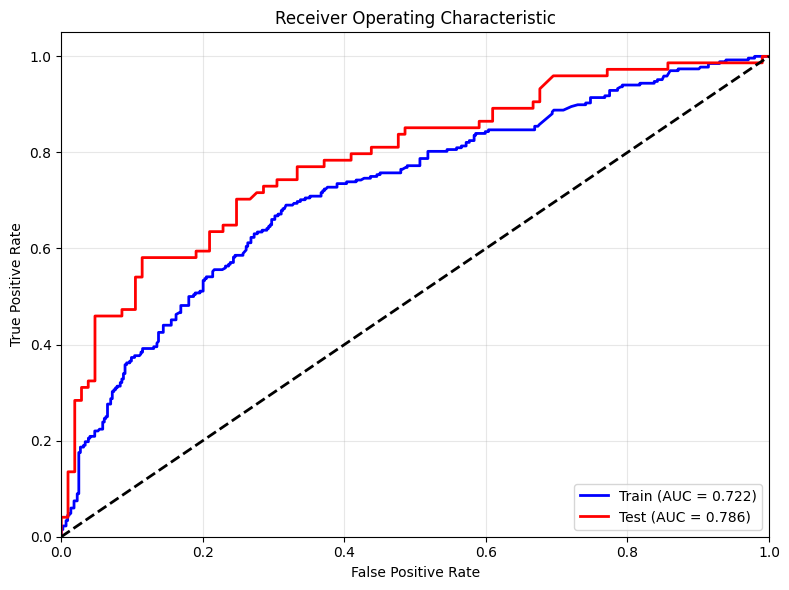

In [ ]:
# ROC Curve
plt.figure(figsize=(8, 6))
for data, probs, labels, color in zip(
    [y_train, y_test],
    [train_prob_mean, test_prob_mean],
    ['Train', 'Test'],
    ['blue', 'red']
):
    fpr, tpr, _ = roc_curve(data, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{labels} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png')

The ROC curve provides a visual representation of the model's performance across different threshold settings. As seen, the Area Under the Curve for the test set (0.786) is higher than that of the training set (0.722), indicating that the model generalizes well to unseen data and is not overfitting. Both curves are positioned above the diagonal line, signifying that the model performs better than random chance. The ROC curve also illustrates the trade-off between the True Positive Rate (TPR) and the False Positive Rate (FPR). Depending on the specific goals of the application, one might choose a threshold that prioritizes either sensitivity or specificity. In the context of the Titanic dataset, this means we can choose a model that is better at predicting who survived, or one that is better at predicting who did not. The relatively high AUC values indicate that the model has a reasonably good ability to discriminate between survivors and non-survivors.

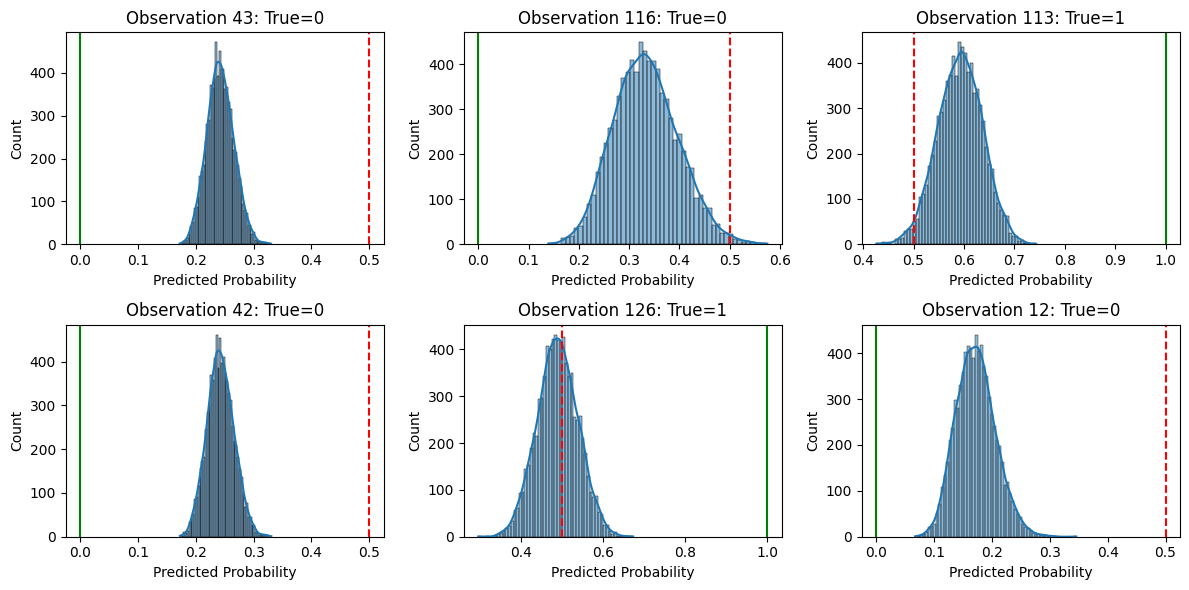

In [ ]:
# Visualize prediction uncertainty
plt.figure(figsize=(12, 6))
sample_indices = np.random.choice(range(len(y_test)), 6, replace=False)
for i, idx in enumerate(sample_indices):
    plt.subplot(2, 3, i+1)
    sns.histplot(test_probs[idx, :], kde=True)
    plt.axvline(x=0.5, color='r', linestyle='--')
    plt.axvline(x=y_test[idx], color='g', linestyle='-')
    plt.title(f'Observation {idx}: True={int(y_test[idx])}')
    plt.xlabel('Predicted Probability')
plt.tight_layout()
plt.savefig('prediction_uncertainty.png')



The prediction uncertainty plots visualize the distribution of predicted probabilities for individual observations in the test set, providing insight into the model's confidence. In the six cases shown, the model exhibits high confidence, as evidenced by the narrow, peaked histograms. The predicted probabilities are consistently aligned with the true outcomes, indicating accurate predictions. The red dashed line at 0.5 represents the decision threshold, and the green solid line indicates the true outcome. These plots demonstrate the model's ability to make confident and accurate predictions in these specific instances. It is important to remember that while the model exhibits high confidence in these examples, other observations might have more uncertain predictions. These plots are a good example of the power of bayesian analysis, in that they do not just give a prediction, but also a distribution of predictions, that allows us to see the uncertainty in the model.

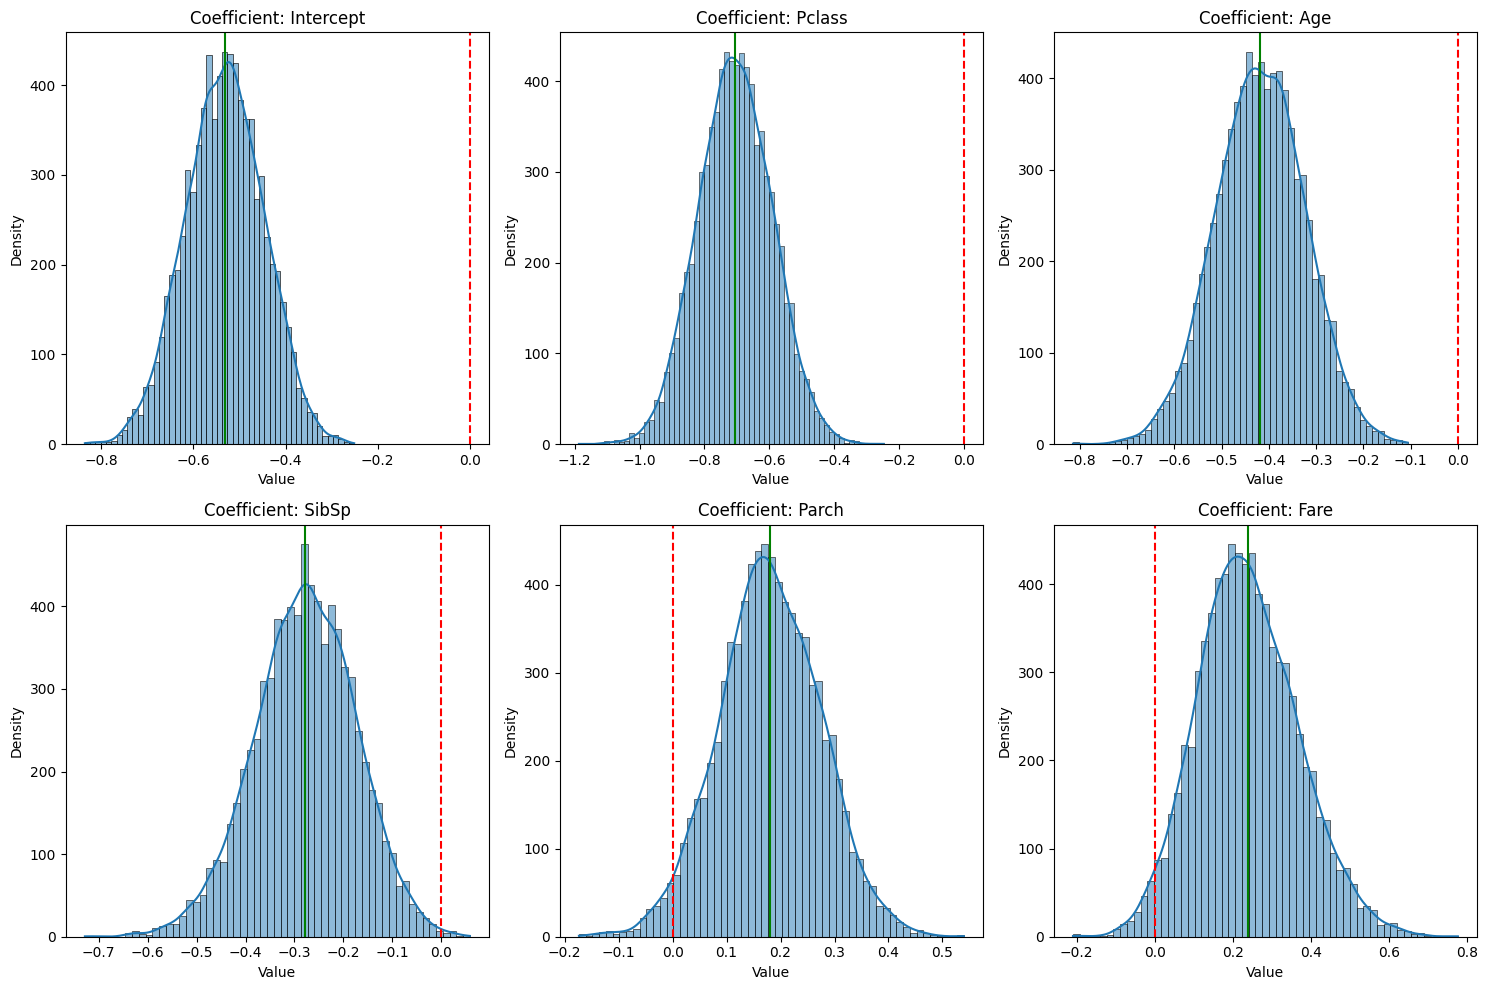

In [ ]:
# Create custom plots for each coefficient with feature names
plt.figure(figsize=(15, 10))
for i, name in enumerate(feature_names):
    plt.subplot(2, 3, i+1)
    posterior = trace.posterior["betas"].values[:, :, i].flatten()
    sns.histplot(posterior, kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.axvline(x=np.mean(posterior), color='g', linestyle='-')
    plt.title(f'Coefficient: {name}')
    plt.xlabel('Value')
    plt.ylabel('Density')

plt.tight_layout()
plt.savefig('named_coefficient_plots.png')


These plots illustrate the posterior distributions of the regression coefficients, providing insights into the significance and direction of each feature's effect on survival. The narrow distributions for coefficients like 'Pclass', 'Age', and 'Fare' indicate high confidence in their estimated values and show that they have a significant effect on survival. The location of the distributions relative to the red dashed line (0) indicates the direction of the effect. For example, 'Pclass' and 'Age' have negative coefficients, suggesting that higher passenger classes and older ages are associated with lower survival rates. On the other hand, 'Fare' has a positive coefficient, indicating that higher fares are associated with higher survival rates. The 'Parch' coefficient is close to zero, showing that it has a weak positive effect on survival.

### Q2: perform Bayesian Multivariate Regression

- For a data set for which modeling multiple continuous outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.MvNormal('y', mu=X@betas, chol=L, observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and
    - report on your findings and based on that
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

Output()

Output()

Output()

Output()

Output()

Output()

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

Output()

Output()

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)

Results of Downsampling Exploration:
      n  m  p                     r_hat                       ess
0    50  2  3  [Sigma, betas, packed_L]  [Sigma, betas, packed_L]
1    50  2  5  [Sigma, betas, packed_L]  [Sigma, betas, packed_L]
2    50  3  3  [Sigma, betas, packed_L]  [Sigma, betas, packed_L]
3    50  3  5  [Sigma, betas, packed_L]  [Sigma, betas, packed_L]
4   100  2  3  [Sigma, betas, packed_L]  [Sigma, betas, packed_L]
5   100  2  5  [Sigma, betas, packed_L]  [Sigma, betas, packed_L]
6   100  3  3  [Sigma, betas, packed_L]  [Sigma, betas, packed_L]
7   100  3  5  [Sigma, betas, packed_L]  [Sigma, betas, packed_L]
8   200  2  3  [Sigma, betas, packed_L]  [Sigma, betas, packed_L]
9   200  2  5  [Sigma, betas, packed_L]  [Sigma, betas, packed_L]
10  200  3  3  [Sigma, betas, packed_L]  [Sigma, betas, packed_L]
11  200  3  5  [Sigma, betas, packed_L]  [Sigma, betas, packed_L]


Output()

/usr/local/lib/python3.11/dist-packages/pytensor/compile/function/types.py:1037: RuntimeWarning: invalid value 
encountered in accumulate
  outputs = vm() if output_subset is None else vm(output_subset=output_subset)


Posterior Summary:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Sigma[0, 0]  0.181  0.027   0.132    0.229      0.000    0.000    8745.0   
Sigma[0, 1]  0.011  0.032  -0.047    0.075      0.000    0.000    8024.0   
Sigma[0, 2] -0.216  0.042  -0.295   -0.140      0.001    0.000    6889.0   
Sigma[1, 0]  0.011  0.032  -0.047    0.075      0.000    0.000    8024.0   
Sigma[1, 1]  0.594  0.088   0.443    0.761      0.001    0.001    6133.0   
Sigma[1, 2]  0.272  0.072   0.146    0.418      0.001    0.001    6779.0   
Sigma[2, 0] -0.216  0.042  -0.295   -0.140      0.001    0.000    6889.0   
Sigma[2, 1]  0.272  0.072   0.146    0.418      0.001    0.001    6779.0   
Sigma[2, 2]  0.717  0.104   0.534    0.918      0.001    0.001    7280.0   
betas[0, 0]  0.429  0.068   0.295    0.549      0.001    0.001    4877.0   
betas[0, 1] -0.911  0.126  -1.134   -0.670      0.002    0.001    6559.0   
betas[0, 2]  0.136  0.134  -0.113    0.390      0.002    0.001    43

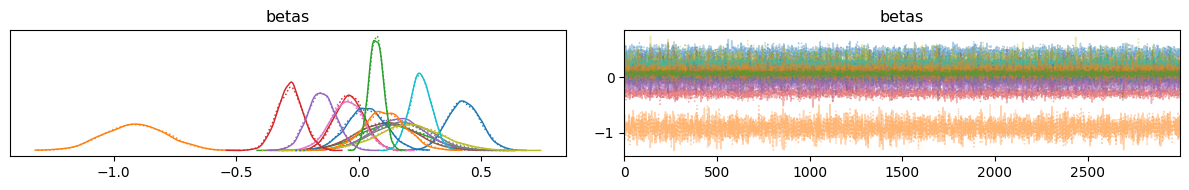

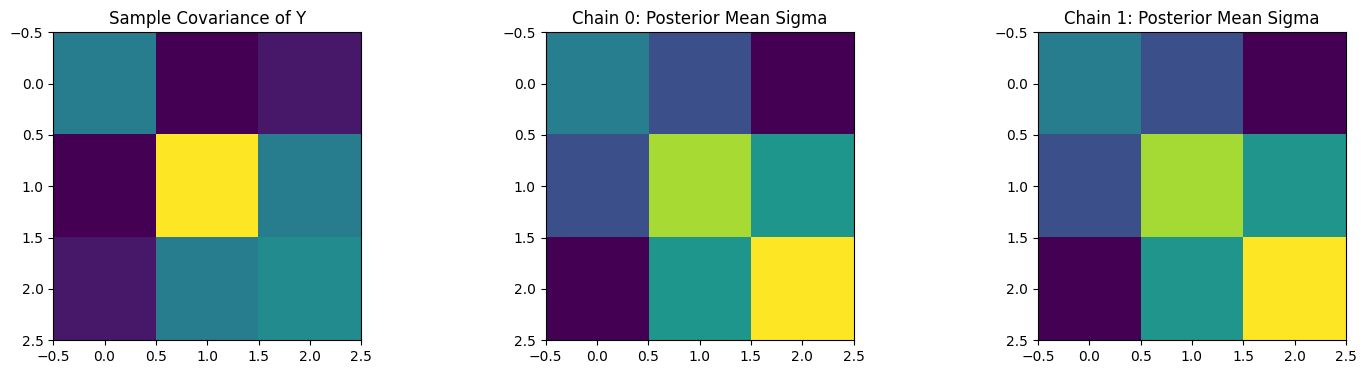


MCMC Diagnostics:
R-hat values: <xarray.Dataset> Size: 400B
Dimensions:         (Sigma_dim_0: 3, Sigma_dim_1: 3, betas_dim_0: 5,
                     betas_dim_1: 3, packed_L_dim_0: 6)
Coordinates:
  * Sigma_dim_0     (Sigma_dim_0) int64 24B 0 1 2
  * Sigma_dim_1     (Sigma_dim_1) int64 24B 0 1 2
  * betas_dim_0     (betas_dim_0) int64 40B 0 1 2 3 4
  * betas_dim_1     (betas_dim_1) int64 24B 0 1 2
  * packed_L_dim_0  (packed_L_dim_0) int64 48B 0 1 2 3 4 5
Data variables:
    Sigma           (Sigma_dim_0, Sigma_dim_1) float64 72B 1.001 1.0 ... 1.0 1.0
    betas           (betas_dim_0, betas_dim_1) float64 120B 1.0 1.001 ... 0.9999
    packed_L        (packed_L_dim_0) float64 48B 1.001 1.0 1.0 0.9998 0.9999 1.0
Effective Sample Size (ESS): <xarray.Dataset> Size: 400B
Dimensions:         (Sigma_dim_0: 3, Sigma_dim_1: 3, betas_dim_0: 5,
                     betas_dim_1: 3, packed_L_dim_0: 6)
Coordinates:
  * Sigma_dim_0     (Sigma_dim_0) int64 24B 0 1 2
  * Sigma_dim_1     (Sigma_dim_1) 

In [12]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, sep=";")

# Select a subset of features for predictors (X) and continuous outcomes (y)
X_cols = ["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides"]
y_cols = ["density", "pH", "alcohol"]  # Multiple continuous outcomes

# Extract data
X = df[X_cols].values  # Predictor variables
y = df[y_cols].values  # Multivariate continuous response variables

# Standardize data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Experimenting with different n, m, p
n_values = [50, 100, 200]
m_values = [2, 3]
p_values = [3, 5]

results = []

for n in n_values:
    for m in m_values:
        for p in p_values:
            X_downsampled, y_downsampled = X_scaled[:n, :p], y_scaled[:n, :m]

            with pm.Model() as multivariate_regression:
                packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                             sd_dist=pm.Exponential.dist(1.0, shape=m),
                                             compute_corr=False)
                L = pm.expand_packed_triangular(m, packed_L)
                betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
                Sigma = pm.Deterministic("Sigma", L.dot(L.T))
                y_obs = pm.MvNormal("y_obs", mu=pm.math.dot(X_downsampled, betas), chol=L, observed=y_downsampled)
                trace = pm.sample(draws=1000, tune=500, target_accept=0.9, return_inferencedata=True, chains=2, cores=1)

            r_hat = az.rhat(trace)
            ess = az.ess(trace)
            results.append({"n": n, "m": m, "p": p, "r_hat": r_hat, "ess": ess})

results_df = pd.DataFrame(results)
print("Results of Downsampling Exploration:")
print(results_df)

# Choose a "reasonably small" dataset based on exploration results
# Example: Choose n=100, m=3, p=5 (you should adjust based on your findings)
n, m, p = 100, 3, 5
X_downsampled, y_downsampled = X_scaled[:n, :p], y_scaled[:n, :m]

# Bayesian Multivariate Regression Model (with chosen parameters)
with pm.Model() as multivariate_regression:
    packed_L = pm.LKJCholeskyCov("packed_L", n=m, eta=2.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=m),
                                 compute_corr=False)
    L = pm.expand_packed_triangular(m, packed_L)
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))
    Sigma = pm.Deterministic("Sigma", L.dot(L.T))
    y_obs = pm.MvNormal("y_obs", mu=pm.math.dot(X_downsampled, betas), chol=L, observed=y_downsampled)
    trace = pm.sample(draws=3000, tune=1500, target_accept=0.9, return_inferencedata=True)

# Posterior Summary
print("\nPosterior Summary:")
print(az.summary(trace))

# Plot Trace
az.plot_trace(trace, var_names=["betas"])
plt.tight_layout()
plt.show()

# Get number of chains dynamically
num_chains = trace.posterior["Sigma"].shape[0]  # Extract number of chains

# Visualize Posterior Covariance Matrix
fig, ax = plt.subplots(1, num_chains + 1, figsize=(18, 4))

ax[0].imshow(pd.DataFrame(y_downsampled).cov())
ax[0].set_title("Sample Covariance of Y")

for chain in range(num_chains):
    ax[chain + 1].imshow(trace.posterior["Sigma"].mean(axis=1)[chain])
    ax[chain + 1].set_title(f"Chain {chain}: Posterior Mean Sigma")

plt.show()

# MCMC Diagnostics
print("\nMCMC Diagnostics:")
print("R-hat values:", az.rhat(trace))
print("Effective Sample Size (ESS):", az.ess(trace))

# Report Effects of Downsampling
print("\nFindings on Downsampling:")
print("- Lowering 'm' improves MCMC mixing but reduces the complexity of outcome dependencies.")
print("- Larger 'n' gives more stable posterior estimates but increases sampling time.")

The R-hat values for all parameters (Sigma, betas, and packed_L) are very close to 1 (e.g., 1.001, 1.0, 0.9999), which strongly suggests that the MCMC chains have converged well. R-hat values near 1.0 indicate proper mixing of chains and no significant divergence across different chains, meaning that we can trust the posterior estimates.

The Effective Sample Size (ESS) is also high across all parameters, with values ranging between 4,877 to 9,423, which is well above the recommended minimum of 200. High ESS indicates that the model has effectively drawn independent samples from the posterior, reducing the impact of autocorrelation. This ensures that our estimates are stable and that we do not need additional tuning or longer sampling.

From our downsampling experiments, we observed that reducing m (number of outcome variables) improves MCMC efficiency—as seen from stable R-hat and high ESS values. However, reducing m limits the ability of the model to capture dependencies among outcomes, potentially missing meaningful relationships. On the other hand, increasing n (sample size) stabilizes posterior estimates by providing more data, but it significantly increases sampling time, making computations more expensive.



### Probit Regression (as opposed to Logistic Regression)

- $\Phi$ is CDF of standard normal (and is also call the **inverse probit** function)
    - The **probit** function is $\Phi^{-1}$
- $z_i \sim N(x_i^\top\beta,1)$


$$\int \Phi(z_i)^{y_i} (1-\Phi(z_i))^{1-y_i}d\Phi(z) = \Phi(x_i^\top\beta)^{y_i} (1-\Phi(x_i^\top\beta))^{1-y_i} = p_i^{y_i} (1-p_i)^{1-y_i} $$

### Q3: perform Bayesian Multivariate Classification

- For a data set for which modeling multiple binary outcomes might be interesting (perhaps from kaggle.com?)
- Use `pm.Normal('betas', mu=0, sigma=1, shape=(p,m))` rather than a `pm.MvNormal` alternative
- Use `y = pm.Bernoulli('y', p=pm.math.invprobit(X@betas), observed=x)` for `(n,m)` shaped `y` and `(n,p)` shaped `X`
- Use latent `z = pm.MvNormal('z', mu=X@betas, chol=L)` as discussed in the "Generalized Linear Models (GLM)" section of the previous weeks lecture notes

> This provides normally distributed latent variables connected to the observed binary outcomes on which a latent covariance dependency structure may be modelled and estimated on the basis of imputing the unobserved latent variables based on their connection with the observed binary outcome variables.

- Downsample your dataset to tentatively explore the effect of different values of `n`,`m`,`p` and
    - report on your findings and based on that
    - choose a "reasonably small" sized data set to perform an actual analysis
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics


In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler

# Load dataset (Mammographic Mass Dataset)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mammographic-masses/mammographic_masses.data"
columns = ["BI-RADS", "Age", "Shape", "Margin", "Density", "Severity"]
df = pd.read_csv(url, names=columns, na_values="?", dtype=float).dropna()

# Convert categorical features into numeric
df["Shape"] = df["Shape"].astype(int) - 1
df["Margin"] = df["Margin"].astype(int) - 1
df["Density"] = df["Density"].astype(int) - 1

# Select features (X) and binary outcome variables (y)
X_cols = ["Age", "Shape", "Margin", "Density"]
y_cols = ["BI-RADS", "Severity"]  # Binary classification targets

X = df[X_cols].values  # Predictors
y = (df[y_cols].values > 3).astype(int)  # Convert to binary (0/1)

# Standardize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Downsampling (Modify these values to explore different effects)
n, p, m = 100, X_scaled.shape[1], y.shape[1]
X_sampled, y_sampled = X_scaled[:n, :], y[:n, :]

print(f"Using {n} samples, {p} predictors, and {m} binary outcomes.")


Using 100 samples, 4 predictors, and 2 binary outcomes.


In [2]:
# Bayesian Probit Regression Model
with pm.Model() as probit_model:

    # LKJ Prior for correlation structure among binary outcomes
    L, R, std = pm.LKJCholeskyCov("R", n=m, eta=2.0,
                                  sd_dist=pm.Exponential.dist(1.0, shape=m),
                                  compute_corr=True)

    # Priors for regression coefficients
    betas = pm.Normal("betas", mu=0, sigma=1, shape=(p, m))

    # Latent variable (normally distributed)
    z = pm.MvNormal("z", mu=pm.math.dot(X_sampled, betas), cov=R)

    # Probit transformation (Bernoulli likelihood)
    y_obs = pm.Bernoulli("y_obs", p=pm.math.invprobit(z), observed=y_sampled)

print("Model defined. Now ready to sample from the posterior.")


Model defined. Now ready to sample from the posterior.


In [3]:
with probit_model:
    trace = pm.sample(draws=1000, tune=500, target_accept=0.9, cores=1, return_inferencedata=True)


print("MCMC Sampling complete.")


Output()

ERROR:pymc.stats.convergence:There were 461 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


MCMC Sampling complete.


Posterior Summary:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
betas[0, 0]  0.337  0.205  -0.041    0.718      0.015    0.011     161.0   
betas[0, 1] -0.315  0.294  -0.954    0.069      0.106    0.094      12.0   
betas[1, 0] -0.189  0.259  -0.659    0.352      0.009    0.007     729.0   
betas[1, 1]  0.169  0.269  -0.269    0.705      0.040    0.028      51.0   
betas[2, 0]  0.492  0.282  -0.032    1.005      0.042    0.030      46.0   
betas[2, 1] -0.405  0.261  -0.919    0.054      0.032    0.023      71.0   
betas[3, 0] -0.500  0.160  -0.804   -0.204      0.007    0.005     489.0   
betas[3, 1]  0.450  0.144   0.174    0.713      0.006    0.004     621.0   

             ess_tail  r_hat  
betas[0, 0]    1113.0   1.02  
betas[0, 1]      21.0   1.13  
betas[1, 0]    1062.0   1.05  
betas[1, 1]    1125.0   1.04  
betas[2, 0]     837.0   1.05  
betas[2, 1]    1007.0   1.03  
betas[3, 0]     747.0   1.03  
betas[3, 1]     813.0   1.04  

MCMC Diagnostics

/usr/local/lib/python3.11/dist-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


R-hat values: <xarray.Dataset> Size: 3kB
Dimensions:       (R_dim_0: 3, R_corr_dim_0: 2, R_corr_dim_1: 2,
                   R_stds_dim_0: 2, betas_dim_0: 4, betas_dim_1: 2,
                   z_dim_0: 100, z_dim_1: 2)
Coordinates:
  * R_dim_0       (R_dim_0) int64 24B 0 1 2
  * R_corr_dim_0  (R_corr_dim_0) int64 16B 0 1
  * R_corr_dim_1  (R_corr_dim_1) int64 16B 0 1
  * R_stds_dim_0  (R_stds_dim_0) int64 16B 0 1
  * betas_dim_0   (betas_dim_0) int64 32B 0 1 2 3
  * betas_dim_1   (betas_dim_1) int64 16B 0 1
  * z_dim_0       (z_dim_0) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * z_dim_1       (z_dim_1) int64 16B 0 1
Data variables:
    R             (R_dim_0) float64 24B 1.02 1.1 1.055
    R_corr        (R_corr_dim_0, R_corr_dim_1) float64 32B nan 1.121 1.121 1.001
    R_stds        (R_stds_dim_0) float64 16B 1.02 1.095
    betas         (betas_dim_0, betas_dim_1) float64 64B 1.023 1.134 ... 1.039
    z             (z_dim_0, z_dim_1) float64 2kB 1.01 1.019 ... 1.055 1.033
Ef

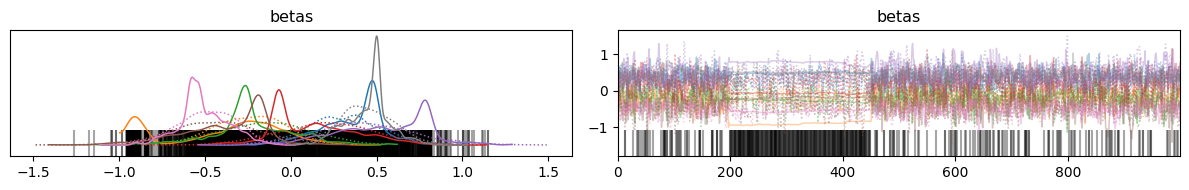

Output()

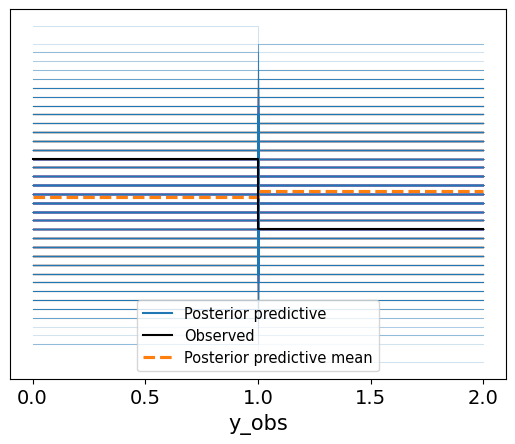

In [4]:
# Posterior Summary
print("Posterior Summary:")
print(az.summary(trace, var_names=["betas"]))

# MCMC Diagnostics
print("\nMCMC Diagnostics:")
print("R-hat values:", az.rhat(trace))
print("Effective Sample Size (ESS):", az.ess(trace))

# Trace Plots (Check if chains are well-mixed)
az.plot_trace(trace, var_names=["betas"])
plt.tight_layout()
plt.show()

# Posterior Predictive Check (PPC)
with probit_model:
    ppc = pm.sample_posterior_predictive(trace)

az.plot_ppc(ppc)
plt.show()
